In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ============================
# 1. Carregar dados
# ============================
gdf = gpd.read_file("../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model.shp")


In [3]:
# ============================
# 2. Preparar dataframe
# ============================
df = gdf[['landform', 'land_use', 'fuel_model', 'ros_p']].dropna()

# Criar log(ros_p) (evitando log(0))
df["log_ros_p"] = np.log(df["ros_p"].replace(0, np.nan))
df = df.dropna(subset=["log_ros_p"])

categoricas = ["landform", "land_use", "fuel_model",]

In [4]:
from scipy import stats

alpha = 0.05
com_diferenca = []
sem_diferenca = []

print("\n===== TESTES KRUSKAL-WALLIS (α = 0.05) =====\n")

for var in categoricas:
    # ros_p
    groups = [g["ros_p"].dropna().values for _, g in df.groupby(var)]
    H, p_ros = stats.kruskal(*groups)

    # log_ros_p
    groups_log = [g["log_ros_p"].dropna().values for _, g in df.groupby(var)]
    H, p_log = stats.kruskal(*groups_log)

    if (p_ros < alpha) or (p_log < alpha):
        com_diferenca.append(var)
        print(f"[SIGNIFICATIVO] {var}: ros_p p={p_ros:.4f} | log_ros_p p={p_log:.4f}")
    else:
        sem_diferenca.append(var)


print("\nVariáveis COM diferença estatisticamente significativa:")
print(com_diferenca)

print("\nVariáveis SEM diferença estatisticamente significativa:")
print(sem_diferenca)



===== TESTES KRUSKAL-WALLIS (α = 0.05) =====

[SIGNIFICATIVO] land_use: ros_p p=0.0020 | log_ros_p p=0.0020
[SIGNIFICATIVO] fuel_model: ros_p p=0.0025 | log_ros_p p=0.0025

Variáveis COM diferença estatisticamente significativa:
['land_use', 'fuel_model']

Variáveis SEM diferença estatisticamente significativa:
['landform']


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "grid.linestyle": "--",
    "grid.alpha": 0.3
})

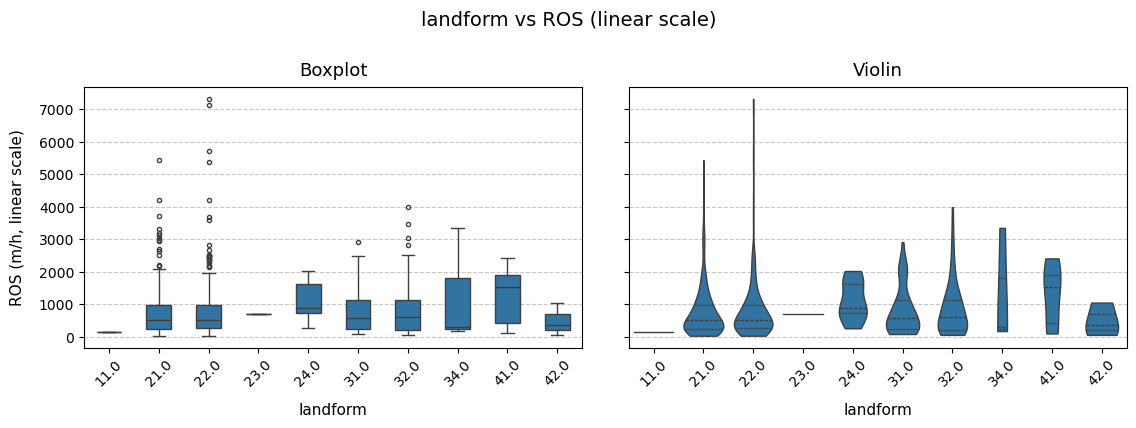

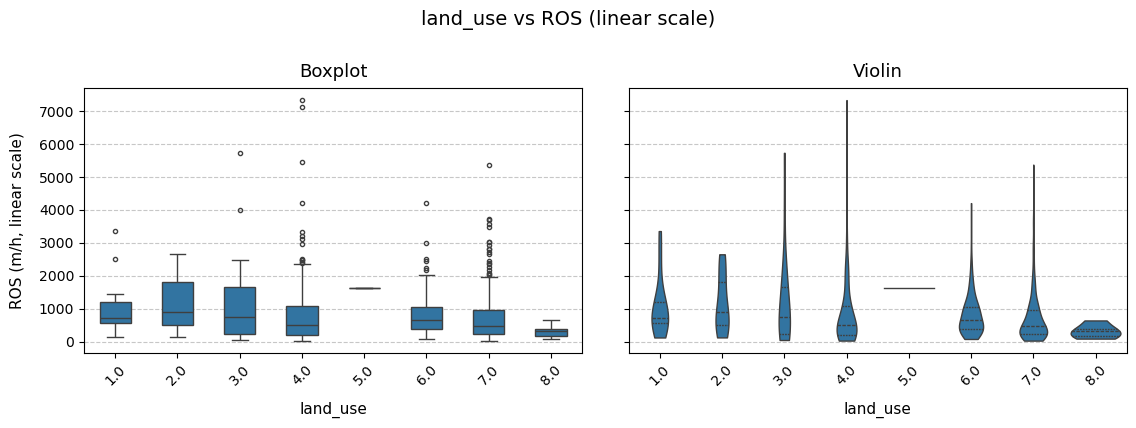

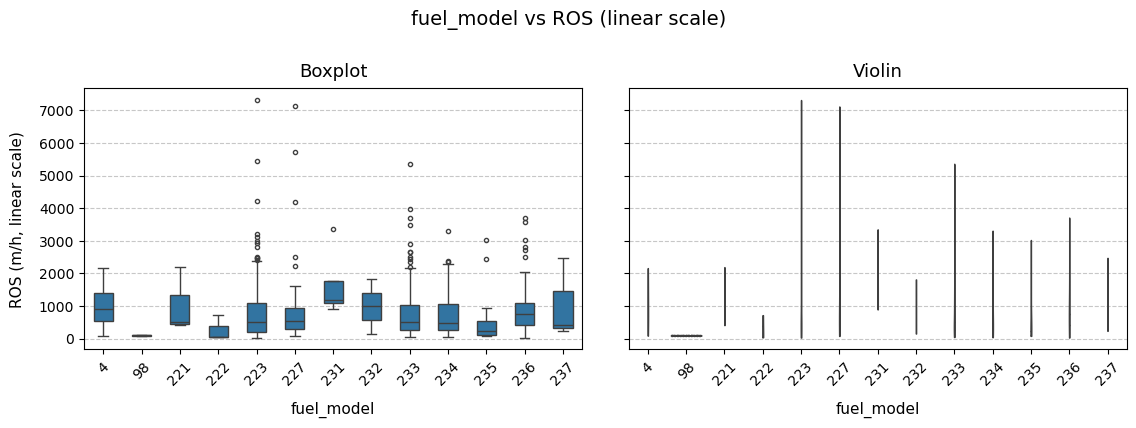

In [6]:
for var in categoricas:

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f"{var} vs ROS (linear scale)", fontsize=14, y=0.9)

    # ---------- BOXPLOT ----------
    sns.boxplot(
        data=df,
        x=var,
        y="ros_p",
        ax=axes[0],
        width=0.5,
        fliersize=3,
        linewidth=1
    )
    axes[0].set_title("Boxplot", pad=8)
    axes[0].set_xlabel(var, labelpad=10)
    axes[0].set_ylabel("ROS (m/h, linear scale)", labelpad=10)
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

    # ---------- VIOLIN ----------
    sns.violinplot(
        data=df,
        x=var,
        y="ros_p",
        ax=axes[1],
        inner="quartile",
        cut=0,
        linewidth=1
    )
    axes[1].set_title("Violin", pad=8)
    axes[1].set_xlabel(var, labelpad=10)
    axes[1].set_ylabel("")
    axes[1].tick_params(axis="x", rotation=45)

    for ax in axes:
        ax.grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.set_axisbelow(True)

    plt.tight_layout(pad=3.0)
    plt.show()


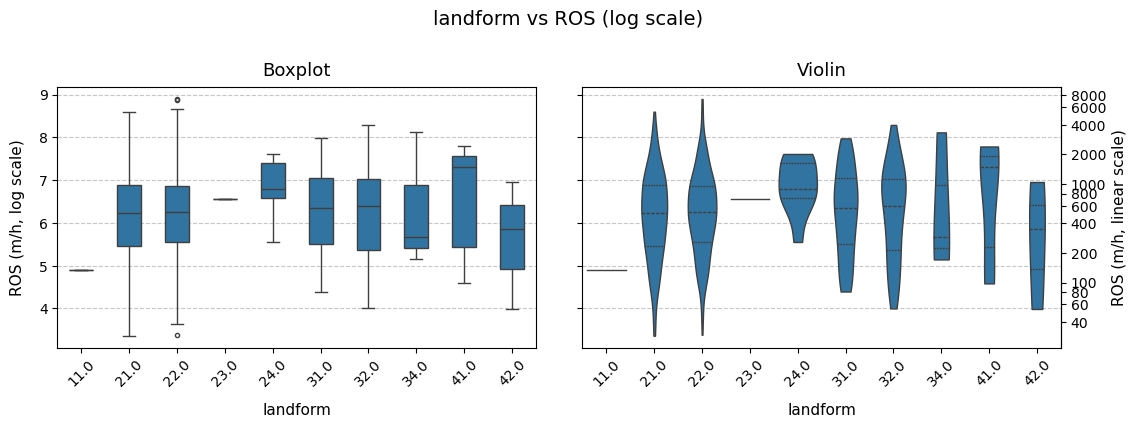

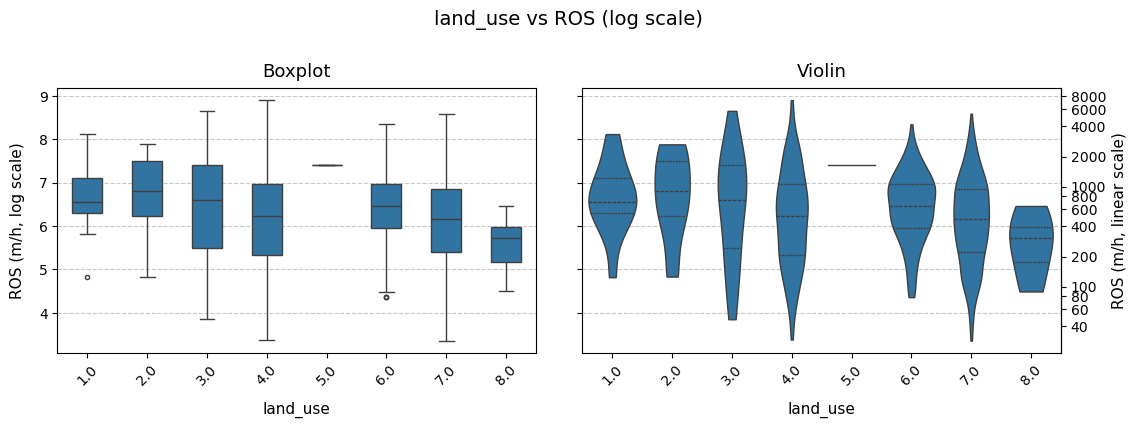

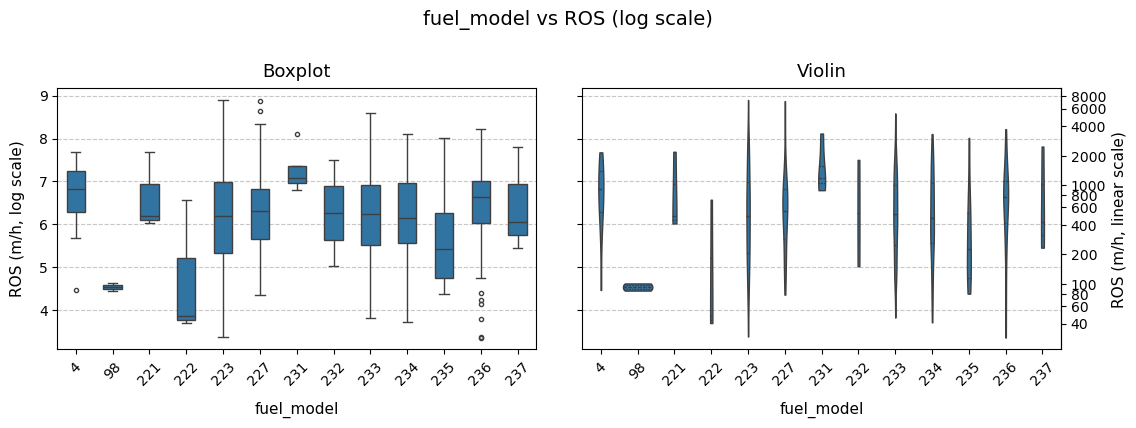

In [7]:
for var in categoricas:

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f"{var} vs ROS (log scale)", fontsize=14, y=0.9)

    # ---------- BOXPLOT ----------
    sns.boxplot(
        data=df,
        x=var,
        y="log_ros_p",
        ax=axes[0],
        width=0.5,
        fliersize=3,
        linewidth=1
    )
    axes[0].set_title("Boxplot", pad=8)
    axes[0].set_xlabel(var, labelpad=10)
    axes[0].set_ylabel("ROS (m/h, log scale)", labelpad=10)
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.7)
    axes[0].set_axisbelow(True)

    # ---------- VIOLIN ----------
    sns.violinplot(
        data=df,
        x=var,
        y="log_ros_p",
        ax=axes[1],
        inner="quartile",
        cut=0,
        linewidth=1
    )
    axes[1].set_title("Violin", pad=8)
    axes[1].set_xlabel(var, labelpad=10)
    axes[1].set_ylabel("")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.7)
    axes[1].set_axisbelow(True)

    # ---------- EIXO SECUNDÁRIO (direita) ----------
    # Funções log <-> linear
    def log_to_linear(y): 
        return np.exp(y)
    def linear_to_log(y): 
        return np.log(y)

    ax2 = axes[1].secondary_yaxis('right', functions=(log_to_linear, linear_to_log))
    ax2.set_ylabel("ROS (m/h, linear scale)")

    # Definir ticks de exemplo (ajuste conforme seu intervalo real)
    linear_ticks = list(range(0, 101, 20)) + list(range(0, 1001, 200)) + list(range(0, 10001, 2000)) 
    ax2.set_yticks(linear_ticks)

    plt.tight_layout(pad=3.0)
    plt.show()


In [8]:
# ============================
# Função para extrair pares significativos
# ============================
def significant_pairs(df_p, alpha=0.05):
    """Retorna uma lista de tuplas (grupo1, grupo2, p-valor) significativos."""
    sig_list = []
    for i in df_p.index:
        for j in df_p.columns:
            val = df_p.loc[i, j]
            if i != j and val < alpha:
                sig_list.append((i, j, val))
    # Ordena por p-valor crescente
    return sorted(sig_list, key=lambda x: x[2])

# ============================
# Dunn teste pós-hoc apenas com pares significativos
# ============================

for var in categoricas:
    print(f"\n===== Pares significativos ({var}) - Dunn =====")
    
    # Dunn teste pós-hoc
    dunn_ros = sp.posthoc_dunn(df, val_col='ros_p', group_col=var, p_adjust='bonferroni')
    dunn_log = sp.posthoc_dunn(df, val_col='log_ros_p', group_col=var, p_adjust='bonferroni')
    
    # Imprime pares significativos ros_p
    sig_ros = significant_pairs(dunn_ros)
    print(f"\nros_p significativos ({var}):")
    for g1, g2, p in sig_ros:
        print(f"{g1} vs {g2}: p = {p:.4f}")
    
    # Imprime pares significativos log_ros_p
    sig_log = significant_pairs(dunn_log)
    print(f"\nlog(ros_p) significativos ({var}):")
    for g1, g2, p in sig_log:
        print(f"{g1} vs {g2}: p = {p:.4f}")



===== Pares significativos (landform) - Dunn =====

ros_p significativos (landform):

log(ros_p) significativos (landform):

===== Pares significativos (land_use) - Dunn =====

ros_p significativos (land_use):
6.0 vs 7.0: p = 0.0311
7.0 vs 6.0: p = 0.0311

log(ros_p) significativos (land_use):
6.0 vs 7.0: p = 0.0311
7.0 vs 6.0: p = 0.0311

===== Pares significativos (fuel_model) - Dunn =====

ros_p significativos (fuel_model):
235 vs 236: p = 0.0240
236 vs 235: p = 0.0240

log(ros_p) significativos (fuel_model):
235 vs 236: p = 0.0240
236 vs 235: p = 0.0240


### ASPECT

In [9]:
gdf['aspect_av'] = np.degrees(
    np.arctan2(gdf['aspect_sin'], gdf['aspect_cos'])
)

# Garantir intervalo 0–360°
gdf['aspect_av'] = (gdf['aspect_av'] + 360) % 360

In [10]:
# ============================
# Preparar dataframe – Aspect
# ============================

df_aspect = gdf[['aspect_av', 'ros_p']].dropna()

# Criar log(ros_p) evitando log(0)
df_aspect["log_ros_p"] = np.log(df_aspect["ros_p"].replace(0, np.nan))
df_aspect = df_aspect.dropna(subset=["log_ros_p"])

In [11]:
# ============================
# Classes de orientação (8 direções)
# ============================
bins = [-0.1, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360.1]
labels = ["N", "NE", "E", "SE", "S", "SO", "O", "NO", "N"]

df_aspect["aspect_av_class"] = pd.cut(
    df_aspect["aspect_av"],
    bins=bins,
    labels=labels,
    right=False,
    ordered=False
)

df_aspect["aspect_av_class"].value_counts()


aspect_av_class
S     149
O     137
SO    119
NO    114
SE    113
E      86
NE     74
N      59
Name: count, dtype: int64

In [12]:
# ============================
# Kruskal-Wallis – teste global
# ============================
print(">>> Kruskal-Wallis (teste global)\n")

alpha = 0.05  # nível de significância

# ros_p
groups = [grp["ros_p"].values for _, grp in df_aspect.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups)
print(f"ros_p: H = {H:.4f}, p = {p:.6f}")
if p < alpha:
    print("Conclusão: Há diferença significativa entre os grupos (p < 0.05).")
else:
    print("Conclusão: Não há diferença significativa entre os grupos (p ≥ 0.05).")

# log_ros_p
groups_log = [grp["log_ros_p"].values for _, grp in df_aspect.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups_log)
print(f"log_ros_p: H = {H:.4f}, p = {p:.6f}")
if p < alpha:
    print("Conclusão: Há diferença significativa entre os grupos (p < 0.05).")
else:
    print("Conclusão: Não há diferença significativa entre os grupos (p ≥ 0.05).")


>>> Kruskal-Wallis (teste global)

ros_p: H = 2.8398, p = 0.899416
Conclusão: Não há diferença significativa entre os grupos (p ≥ 0.05).
log_ros_p: H = 2.8398, p = 0.899416
Conclusão: Não há diferença significativa entre os grupos (p ≥ 0.05).


In [13]:
# ============================
# Função para extrair pares significativos
# ============================
def significant_pairs(df_p, alpha=0.05):
    """Retorna uma lista de tuplas (grupo1, grupo2, p-valor) significativos."""
    sig_list = []
    for i in df_p.index:
        for j in df_p.columns:
            val = df_p.loc[i, j]
            if i != j and val < alpha:
                sig_list.append((i, j, val))
    # Ordena por p-valor crescente
    return sorted(sig_list, key=lambda x: x[2])

# ============================
# Dunn pós-hoc – pares significativos
# ============================

dunn_aspect_ros = sp.posthoc_dunn(
    df_aspect,
    val_col='ros_p',
    group_col='aspect_av_class',
    p_adjust='bonferroni'
)

dunn_aspect_log = sp.posthoc_dunn(
    df_aspect,
    val_col='log_ros_p',
    group_col='aspect_av_class',
    p_adjust='bonferroni'
)

# pares significativos ros_p
sig_ros = significant_pairs(dunn_aspect_ros)
print("Pares significativos – ros_p:")
if sig_ros:
    for g1, g2, p in sig_ros:
        print(f"{g1} vs {g2}: p = {p:.4f}")
else:
    print("Nenhum par significativo.")

# pares significativos log_ros_p
sig_log = significant_pairs(dunn_aspect_log)
print("\nPares significativos – log_ros_p:")
if sig_log:
    for g1, g2, p in sig_log:
        print(f"{g1} vs {g2}: p = {p:.4f}")
else:
    print("Nenhum par significativo.")


Pares significativos – ros_p:
Nenhum par significativo.

Pares significativos – log_ros_p:
Nenhum par significativo.


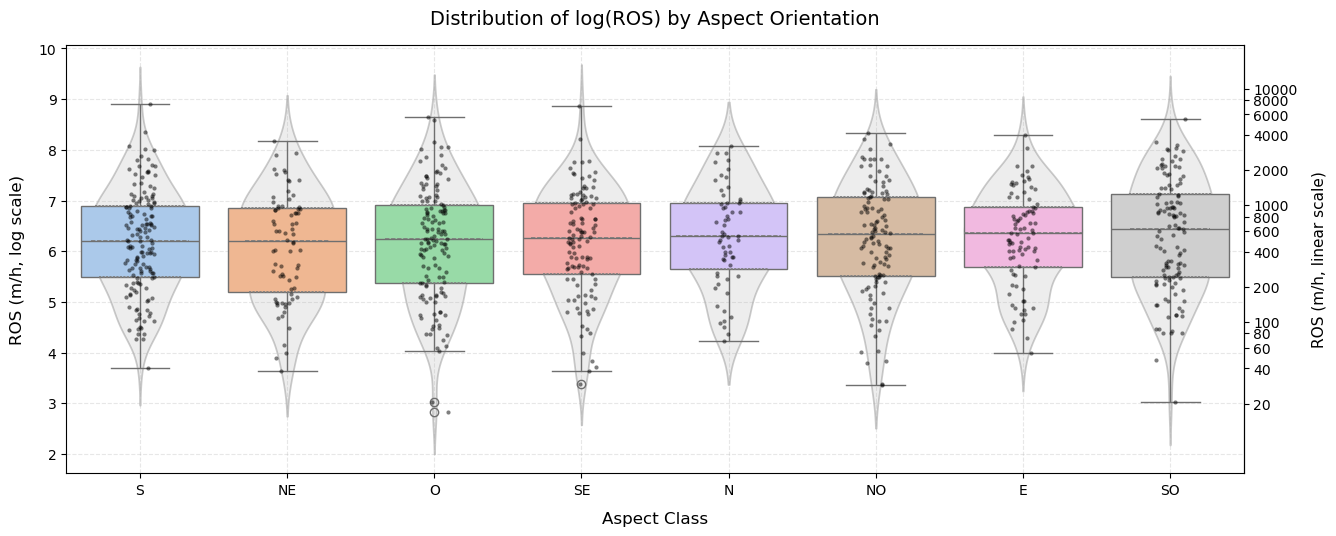

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# ============================
# Ordenação por mediana de log_ros_p
# ============================
ordem_mediana = (
    df_aspect
    .groupby("aspect_av_class")["log_ros_p"]
    .median()
    .sort_values()
    .index
    .tolist()
)

# ============================
# Visualização final estilizada
# ============================
plt.figure(figsize=(14, 6))

ax = plt.gca()  # pegar o eixo atual

# Boxplot
sns.boxplot(
    data=df_aspect,
    x="aspect_av_class",
    y="log_ros_p",
    order=ordem_mediana,
    ax=ax,
    palette="pastel"
)

# Violinplot
sns.violinplot(
    data=df_aspect,
    x="aspect_av_class",
    y="log_ros_p",
    order=ordem_mediana,
    inner="quartile",
    color="lightgray",
    alpha=0.4,
    ax=ax
)

# Stripplot
sns.stripplot(
    data=df_aspect,
    x="aspect_av_class",
    y="log_ros_p",
    order=ordem_mediana,
    color='black',
    size=3,
    alpha=0.5,
    jitter=True,
    ax=ax
)

# Título e labels em inglês
ax.set_title("Distribution of log(ROS) by Aspect Orientation", fontsize=14, pad=15)
ax.set_xlabel("Aspect Class", fontsize=12, labelpad=10)
ax.set_ylabel("ROS (m/h, log scale)", fontsize=12, labelpad=10)

# Gridlines suaves
ax.grid(True, linestyle='--', alpha=0.3)

# Ticks inteiros no eixo y
ax.yaxis.set_major_locator(MaxNLocator(integer=False))

# Eixo secundário X mostrando ROS linear
ax2 = ax.secondary_yaxis('right', functions=(np.exp, np.log))
ax2.set_ylabel("ROS (m/h, linear scale)", fontsize=11, labelpad=10)

# Ajustar ticks secundários (escala linear)
y_linear_ticks = list(range(0, 101, 20)) + list(range(0, 1001, 200)) + list(range(0, 10001, 2000)) 
ax2.set_yticks(y_linear_ticks)

plt.tight_layout(pad=3.0)
plt.show()
